
# Transfer Learning with Pytorch

In this excercise, you will implement a 2-class classification neural network, using transfer learning from a pre-trained resnet18 network. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve (but not identical). The pre-trained network could have been trained on a different dataset and sometimes also on a different task. The important thing is that it would be a related task and a realted dataset. This way, we can leverage previous learneinng to solve the new problem (instead of training the model from scratch). The ResNet18 model was pre-trained on the [ImageNet](http://image-net.org/index) dataset (a large dataset consisting of 1.4M images and 1000 classes). 

Transfer learning can be used in two ways:
1. Feature extractor: Here we remove top layers, freeze the weights of all remaining layers, add a new fully connected layers on top of the pretrained model. Then. we train only these new layers to solve the new task.
2. Fine tuning: Here we unfreezing the entire model (or part of it), add a new fully connected layers on top of the pre-trained model (as before) and re-train the entire model on the new data with a very low learning rate. We can use either end-to-end re-training, or re-train only part of the network.

### CIFAR-10 Dataset:

In this assignment, you will need to perform transfer learning using the ResNet18 network in order to classify and discern between images of cats and dogs in a different dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 



# Part 1- Feature Extractor

In this part of the exercise, you need to classify images of 'Cat' and 'Dog' by using transfer learning with the feature extractor approach and a pre-trained ResNet18 network.

The pre-trained model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers. You will need to extract the image representation that should be fed into a classifier. For the classifier, please use a single fully-connected layer. 


In order to make things efficient, start by using the ResNet18 network in order to extract image represetnations for the images in CIFAR-10 dataset. Please make sure to this only once (please do not extract the image representations each time it is needed in the training phase)! You can store the resulting image representations as feature vectors and train the classifier using these vectors. At test time, you can merge both network in order to achive a single end-to-end classifier.  
Note: This is different from what you saw in the recitation (dl_r4_cnns).

At the test time, you can merge the feature extraction netowork with the new prediction head, in order to recive a "full solution".


**Let's first import all the packages that you will need during this part of assignment:**

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time

import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import copy

The ResNet18 network requires images of at least 200x200 pixels. However, the CIFAR-10 dataset consists of small images of 32x32 pixels. Hence, you will need to reshape the images before we use them into the ResNet18 network.
Additionally, you will need to match the normalization used while training the ResNet18: each color channel should be normalized separately. The channel means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

**Use the transforms library from  torchvision and definethese transformations:**

In [2]:
# Specify transforms using torchvision.transforms as transforms library
# first, resize tthe picture to be in the correct size, convert to tensor and finally normalize.
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#### Load CIFAR10 dataset and transform dataset from torchvision:

In [3]:
# load the train and test sets and apply the transform
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


**Note that the CIFAR10 data set includes 10 labels. Please extract from the entire dataset, only the images with 'Cat' or 'Dog' labels.
In order to make the training process faster, you will need to trim the train set to 800 training images of each label (800 dogs and 800 cats). The test set should be trimmed to 250 images of cats and 250 images of dogs.**

<b>arrange the train set:

In [4]:
# get the indexes only for classes of cat and dog
cat_index_train = train.classes.index('cat')
dog_index_train = train.classes.index('dog')

# get the indices where we have cat and dog in the train set (by the indexes we got before)
idx_train_cat_train = torch.tensor(train.targets) == cat_index_train
idx_train_dog_train = torch.tensor(train.targets) == dog_index_train

# get the indexes where we indeed have the cat/dog (we have True from the previous condition) and leave 800 samples for each
idx_train_cat_arrange_train = (torch.where(idx_train_cat_train==True))[0][0:800]
idx_train_dog__arrange_train = (torch.where(idx_train_dog_train==True))[0][0:800]

# concatenate all the indexes we want in the train set (dog/cat)
cat_dog_idx_train = torch.cat((idx_train_cat_arrange_train, idx_train_dog__arrange_train), 0)
# define the train set with the correct indexes
train.data = train.data[cat_dog_idx_train]
# get the targets of this train set
train.targets = torch.tensor(train.targets)[cat_dog_idx_train]

<b>arrange the test set:

In [5]:
# arrange the test set
# get the indexes only for classes of cat and dog
cat_index_test = test.classes.index('cat')
dog_index_test = test.classes.index('dog')

# get the indices where we have cat and dog in the test set (by the indexes we got before)
idx_test_cat_test = torch.tensor(test.targets) == cat_index_test
idx_test_dog_test = torch.tensor(test.targets) == dog_index_test

# get the indexes where we indeed have the cat/dog (we have True from the previous condition) and leave 800 samples for each
idx_test_cat_arrange_test = (torch.where(idx_test_cat_test==True))[0][0:250]
idx_test_dog_arrange_test = (torch.where(idx_test_dog_test==True))[0][0:250]

# concatenate all the indexes we want in the test set (dog/cat)
cat_dog_idx_test = torch.cat((idx_test_cat_arrange_test, idx_test_dog_arrange_test), 0)
# define the test set with the correct indexes
test.data = test.data[cat_dog_idx_test]
# get the targets of this test set
test.targets = torch.tensor(test.targets)[cat_dog_idx_test]

<b> change targets to be 0 and 1: </b> 0 for cat and 1 for dog

In [6]:
# change the cat target index to be 0
# get the indexes where we have the old index of cat in train set and change them to be 0
indexes = (train.targets == cat_index_train)
train.targets[indexes] = 0
# get the indexes where we have the old index of cat in test set and change them to be 0
indexes = (test.targets == cat_index_test)
test.targets[indexes] = 0

# change the dog target index to be 1
# get the indexes where we have the old index of dog in train set and change them to be 1
indexes = (train.targets == dog_index_train)
train.targets[indexes] = 1
# get the indexes where we have the old index of dog in test set and change them to be 1
indexes = (test.targets == dog_index_test)
test.targets[indexes] = 1

**Download the ResNet18 Network from torchvision.models (as seen in the tutorial):**

In [7]:
# load resnet18 network
model_resnet_18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### Now, use the pre-trained Resnet18 to extract feautres from the CIFAR10 dataset and feed your classifier with these feature vectors. To do that, you need to cut the head of the pre-trained ResNet18 model, then feed the model with the CIFAR10 data sets (train and test).  The resulting image representations should be "flattened" and used as feature vectors:

In [7]:
# define the sizes of each class in each set (train/test)
train_size_class = 800
test_size_class = 250

In [8]:
# define DataLoader for each set (train/test)
train_loader = torch.utils.data.DataLoader(train, batch_size=train_size_class*2, shuffle=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_size_class*2, shuffle=1)

In [9]:
# get the X and Y of train set and test set from the DataLoaders we defined above
x_train_resnet, y_train = next(iter(train_loader))
x_test_resnet, y_test = next(iter(test_loader))

In [11]:
# get the size of the classifier input
num_features = model_resnet_18.fc.in_features 
# cut the head of the pre-trained model we got from resnet
model_resnet_18.fc = nn.Sequential() 

In [12]:
# get the feature vectors for the train set
model_resnet_18.eval() 
x_train = model_resnet_18(x_train_resnet) 
# get the feature vectors for the test set
model_resnet_18.eval()
x_test = model_resnet_18(x_test_resnet)

In [13]:
y_train.shape

torch.Size([1600])

# Logistic Regression with scikit-learn library:

#### Here, you need to use a logistic regession model from scikit-learn and train it with the data you prepared above. You need to calculate and report the accuracy and AUC for the train and test sets and explain your results.

In [14]:
# convert all the data and labels (train+test) to numpy array
x_train_np = x_train.data.numpy()
y_train_np = y_train.numpy()
x_test_np = x_test.data.numpy()
y_test_np = y_test.numpy()

# define the classifier to logistic regression and fit the train data
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train_np, y_train_np)

# predict the probability for each class on the train and test data- need for AUC
y_prob_hat_train_lr = LR.predict_proba(x_train_np)
y_prob_hat_test_lr = LR.predict_proba(x_test_np)

# predict the lables on the train and test data- need for accuracy
y_hat_train_lr = LR.predict(x_train_np)
y_hat_test_lr = LR.predict(x_test_np)

# calculate and print all the measures we need
print('Train AUC:', roc_auc_score(y_train_np, y_prob_hat_train_lr[:,1]))
print('Test AUC:', roc_auc_score(y_test_np, y_prob_hat_test_lr[:,1]))
print('Train Accuracy:', 100 * np.sum(y_train_np == y_hat_train_lr) / len(y_hat_train_lr),'%')
print('Test Accuracy:', 100 * np.sum(y_test_np == y_hat_test_lr) / len(y_hat_test_lr),'%')

Train AUC: 0.9728703125
Test AUC: 0.934944
Train Accuracy: 90.5 %
Test Accuracy: 85.0 %


<b> Explanation: </b><br>
As can be seen above, the measures of the train data is higher than the measures of the test data.
We expected to get these values because the whole network was trained on the training data and therefore the measures of the training data are higher. The accuracy of the test data is around 93% and the AUC of the test data is 85%. Both measures are above 85%. This indicates for good results.

# Logistic Regression with pytorch:

#### Next, you need to use a logistic regession using pythourch as follows:


1. Explain the choice of architecture in the head of the neural network.
2. Plot training loss per epoch.
3. Plot AUC per epoch for train and validation sets.
4. Explain your results and findings.
5. Does adding one or two hidden layers affect the generalization capabilities of the model?

#### Define the model:

In [15]:
# convert all the data and labels (train+test) from numpy array to FloatTensor
x_train_t = torch.FloatTensor(x_train_np)
x_test_t = torch.FloatTensor(x_test_np)
y_train_t = torch.FloatTensor(y_train_np).reshape(-1,1)
y_test_t = torch.FloatTensor(y_test_np).reshape(-1,1)

<b> Explanation for the architecture: </b><br>
in the head of the NN we need to use the architecture of logistic regression, just as we did in exercise 1. <br>
So, we use one layer network that ends with one neuron (one binary classification) and sigmoid function as we learn we need for logistic regression.

In [16]:
# for binary classification we need one nodes in the output
n_output = 1
# One layer network that ends with one neuron and sigmoid function
net_18_lr = nn.Sequential(nn.Linear(num_features, n_output), nn.Sigmoid())
net_18_lr

Sequential(
  (0): Linear(in_features=512, out_features=1, bias=True)
  (1): Sigmoid()
)

In [17]:
# define the loss function (binary cross entropy for logistic), learning rate and the optimizer
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net_18_lr.parameters(), lr=learning_rate)

#### Training and validation:

In [18]:
# reset all the parameters
for layer in net_18_lr.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
# resetting the gradinates        
optimizer.zero_grad()
# create lists for loss, accuracy and auc that will save the parameters from the different iterations for the plots
train_loss = []
train_accuracy = []
train_auc = []
test_auc = []
# define numer of iterations
iters = 100

# for each iteration
for i in range(iters):
    # apply the net with the train and test data
    y_hat_train = net_18_lr(x_train_t)
    y_hat_test = net_18_lr(x_test_t)
     # compute the loss value with the predicted values of train with the true labels
    loss = loss_func(y_hat_train, y_train_t)
     # apply the backward with the loss we got
    loss.backward()
    # apply step for the updates
    optimizer.step()
    # resetting the gradinates
    optimizer.zero_grad()
    
    # convert lables to 0 and 1
    y_hat_train_class = np.where(y_hat_train.detach().numpy() < 0.5, 0, 1)
    # compute accuracy for train set and append it to the appropriate list
    accuracy = np.sum(y_hat_train_class == y_train_t.detach().numpy().reshape(-1, 1)) / len(y_train_t)
    train_accuracy.append(accuracy)
    # compute AUC for train set and append it to the appropriate list
    auc = roc_auc_score(y_train_t, y_hat_train.detach().numpy())
    train_auc.append(auc)
    # compute AUC for test set and append it to the appropriate list
    auc = roc_auc_score(y_test_t, y_hat_test.detach().numpy())
    test_auc.append(auc)
    # append the loss to the appropriate list
    train_loss.append(loss.item())


#### Visualizing the plots:

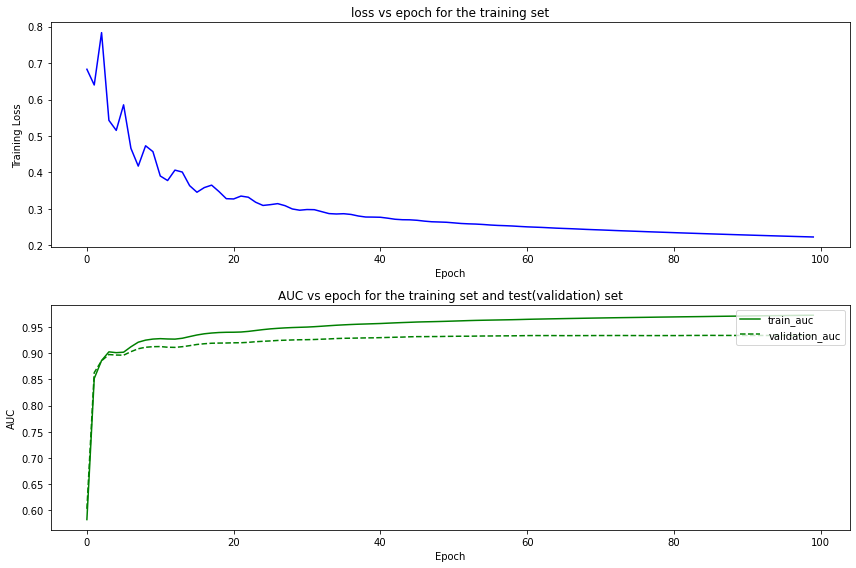

Train AUC: 0.973, Validation AUC: 0.934
Train Accuracy: 90.750 %
Validation Accuracy: 84.800 %


In [19]:
# plot the AUC and loss vs epoch for the training set and test set
# create figure for all the  plots
fig = plt.figure(figsize=(12, 8))

# create train loss plot and add lables and title
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(train_loss , color='blue')
ax1.set_ylabel('Training Loss')
ax1.set_xlabel("Epoch")
ax1.title.set_text('loss vs epoch for the training set')

# create AUC plot for train and test sets and add lables and title
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(train_auc, label='train_auc', color='green')
ax2.plot(test_auc, label='validation_auc', color='green', linestyle='--')
ax2.legend(loc=1)
ax2.set_ylabel('AUC')
ax2.set_xlabel("Epoch")
ax2.title.set_text('AUC vs epoch for the training set and test(validation) set')
# add spaces between the sub plots
plt.tight_layout()
plt.show()

# compute accurcay for ptinting
# apply the net with the test data
y_hat_test = net_18_lr(x_test_t)
# convert lables to 0 and 1
y_hat_test_class = np.where(y_hat_test.data.numpy() < 0.5, 0, 1)
# compute accuracy 
test_accuracy = np.sum(y_hat_test_class == y_test_t.data.numpy()) / len(y_hat_test_class)

# print measures
print('Train AUC: %.3f, Validation AUC: %.3f' % (train_auc[-1], test_auc[-1]))
print('Train Accuracy: %.3f %s' % (train_accuracy[-1] * 100, '%'))
print('Validation Accuracy: %.3f %s' % (test_accuracy * 100, '%'))

<b> explanation: </b><br>
As can be seen above, the training loss decreases as long as the number of Epochs increases. In addition, the AUC for the train data increases with the number of Epochs while the AUC of the validation data stops increasing from some point and therefore we chose 100 Epochs for the training stage.
The test AUC and accuracy are similar for both torch and sklearn regressions. The train AUC and accuracy is a bit higher on the sklearn regression. We assume that this happened because we chose 100 Epochs for the tensor network in order to prevent overfitting.

<b> Question 5:

In [20]:
# for binary classification we need one nodes in the output
n_output = 1
# 3 layer network (2 hidden layers) that ends with one neuron and sigmoid function
net_18_lr_temp = nn.Sequential(nn.Linear(num_features,50), nn.Sigmoid(),nn.Linear(50,10), nn.Sigmoid(), nn.Linear(10, n_output), nn.Sigmoid())

In [21]:
# reset all the parameters
for layer in net_18_lr_temp.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
# resetting the gradinates        
optimizer.zero_grad()
# create lists for loss, accuracy and auc that will save the parameters from the different iterations for the plots
train_loss = []
train_accuracy = []
train_auc = []
test_auc = []
# define numer of iterations
iters = 1000

# for each iteration
for i in range(iters):
    # apply the net with the train and test data
    y_hat_train = net_18_lr_temp(x_train_t)
    y_hat_test = net_18_lr_temp(x_test_t)
     # compute the loss value with the predicted values of train with the true labels
    loss = loss_func(y_hat_train, y_train_t)
     # apply the backward with the loss we got
    loss.backward()
    # apply step for the updates
    optimizer.step()
    # resetting the gradinates
    optimizer.zero_grad()
    
    # convert lables to 0 and 1
    y_hat_train_class = np.where(y_hat_train.detach().numpy() < 0.5, 0, 1)
    # compute accuracy for train set and append it to the appropriate list
    accuracy = np.sum(y_hat_train_class == y_train_t.detach().numpy().reshape(-1, 1)) / len(y_train_t)
    train_accuracy.append(accuracy)
    # compute AUC for train set and append it to the appropriate list
    auc = roc_auc_score(y_train_t, y_hat_train.detach().numpy())
    train_auc.append(auc)
    # compute AUC for test set and append it to the appropriate list
    auc = roc_auc_score(y_test_t, y_hat_test.detach().numpy())
    test_auc.append(auc)
    # append the loss to the appropriate list
    train_loss.append(loss.item())


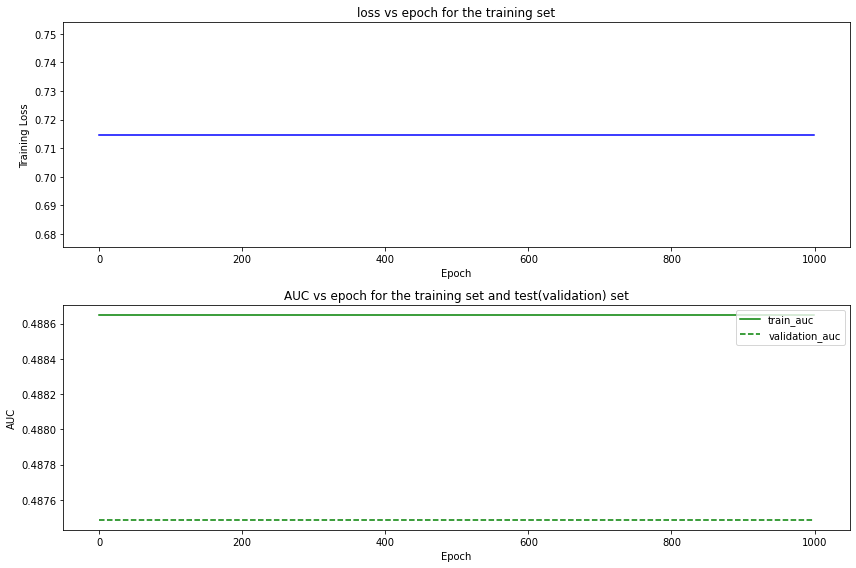

Train AUC: 0.489, Validation AUC: 0.487
Train Accuracy: 50.000 %
Validation Accuracy: 50.000 %


In [22]:
# plot the AUC and loss vs epoch for the training set and test set
# create figure for all the  plots
fig = plt.figure(figsize=(12, 8))

# create train loss plot and add lables and title
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(train_loss , color='blue')
ax1.set_ylabel('Training Loss')
ax1.set_xlabel("Epoch")
ax1.title.set_text('loss vs epoch for the training set')

# create AUC plot for train and test sets and add lables and title
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(train_auc, label='train_auc', color='green')
ax2.plot(test_auc, label='validation_auc', color='green', linestyle='--')
ax2.legend(loc=1)
ax2.set_ylabel('AUC')
ax2.set_xlabel("Epoch")
ax2.title.set_text('AUC vs epoch for the training set and test(validation) set')
# add spaces between the sub plots
plt.tight_layout()
plt.show()

# compute accurcay for ptinting
# apply the net with the test data
y_hat_test = net_18_lr_temp(x_test_t)
# convert lables to 0 and 1
y_hat_test_class = np.where(y_hat_test.data.numpy() < 0.5, 0, 1)
# compute accuracy 
test_accuracy = np.sum(y_hat_test_class == y_test_t.data.numpy()) / len(y_hat_test_class)

# print measures
print('Train AUC: %.3f, Validation AUC: %.3f' % (train_auc[-1], test_auc[-1]))
print('Train Accuracy: %.3f %s' % (train_accuracy[-1] * 100, '%'))
print('Validation Accuracy: %.3f %s' % (test_accuracy * 100, '%'))

<b>Explanation:</b><br>Adding two complex hidden layers may affect the generalization capabilities of the model. As can be seen above, both AUC and accuracy for the train and test data are lower when we complex the network structure. 

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [23]:
# merge the logistic regression (we did with pytorch) with the network
model_resnet_18.fc = net_18_lr

# Comparing  ResNet18 with ResNet34:

#### Download the ResNet34 Network from torchvision.models. Then, repeat the steps described above in order to compare between these ResNet18 and ResNet43. Explain your findings and results!

In [10]:
# load resnet34 network
model_resnet_34 = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
# get the X and Y of train set and test set from the DataLoaders we defined above
x_train_resnet, y_train = next(iter(train_loader))
x_test_resnet, y_test = next(iter(test_loader))

In [12]:
# get the size of the classifier input
num_features = model_resnet_34.fc.in_features
# cut the head of the pre-trained model we got from resnet
model_resnet_34.fc = nn.Sequential()

In [13]:
# get the feature vectors for the train set
model_resnet_34.eval() 
x_train = model_resnet_34(x_train_resnet)
# get the feature vectors for the test set
model_resnet_34.eval()
x_test = model_resnet_34(x_test_resnet)

# Logistic Regression with scikit-learn library:

In [14]:
# convert all the data and labels (train+test) to numpy array
x_train_np = x_train.data.numpy()
y_train_np = y_train.numpy()
x_test_np = x_test.data.numpy()
y_test_np = y_test.numpy()

# define the classifier to logistic regression and fit the train data
LR = LogisticRegression(C=0.1, solver='liblinear').fit(x_train_np, y_train_np)

# predict the probability for each class on the train and test data- need for AUC
y_hat_train_Prob_lr = LR.predict_proba(x_train_np)
y_hat_test_Prob_lr = LR.predict_proba(x_test_np)

# predict the lables on the train and test data- need for accuracy
y_hat_train_lr = LR.predict(x_train_np)
y_hat_test_lr = LR.predict(x_test_np)

# calculate and print all the measures we need
print('Train AUC:', roc_auc_score(y_train_np, y_hat_train_Prob_lr[:,1]))
print('Test AUC:', roc_auc_score(y_test_np, y_hat_test_Prob_lr[:,1]))
print('Train Accuracy:', 100 * np.sum(y_train_np == y_hat_train_lr) / len(y_hat_train_lr),'%')
print('Test Accuracy:', 100 * np.sum(y_test_np == y_hat_test_lr) / len(y_hat_test_lr),'%')

Train AUC: 0.9943625
Test AUC: 0.9377120000000001
Train Accuracy: 96.0 %
Test Accuracy: 86.4 %


<b> Explanation: </b><br>
As can be seen above, the measures of the train data is higher than the measures of the test data.
We expected to get these values because the whole network was trained on the training data and therefore the measures of the training data are higher. The accuracy of the test data is around 86.4% and the AUC of the test data is 93.7%. Both measures are above 86%. This indicates for good results.


# Logistic Regression with pytorch for ResNet34:

#### Define the model:

In [15]:
# convert all the data and labels (train+test) from numpy array to FloatTensor
x_train_t = torch.FloatTensor(x_train_np)
x_test_t = torch.FloatTensor(x_test_np)
y_train_t = torch.FloatTensor(y_train_np).reshape(-1,1)
y_test_t = torch.FloatTensor(y_test_np).reshape(-1,1)

In [16]:
# for binary classification we need one nodes in the output
n_output = 1 
# One layer network that ends with one neuron and sigmoid function
net_34_lr = nn.Sequential(nn.Linear(num_features, n_output), nn.Sigmoid())
net_34_lr

Sequential(
  (0): Linear(in_features=512, out_features=1, bias=True)
  (1): Sigmoid()
)

In [17]:
# define the loss function (binary cross entropy for logistic), learning rate and the optimizer
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net_34_lr.parameters(), lr=learning_rate)

#### Training and validation:

In [18]:
# reset all the parameters
for layer in net_34_lr.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
# resetting the gradinates        
optimizer.zero_grad()
# create lists for loss, accuracy and auc that will save the parameters from the different iterations for the plots
train_loss = []
train_accuracy = []
train_auc = []
test_auc = []
# define numer of iterations
iters = 50

# for each iteration
for i in range(iters):
    # apply the net with the train and test data
    y_hat_train = net_34_lr(x_train_t)
    y_hat_test = net_34_lr(x_test_t)
     # compute the loss value with the predicted values of train with the true labels
    loss = loss_func(y_hat_train, y_train_t)
     # apply the backward with the loss we got
    loss.backward()
    # apply step for the updates
    optimizer.step()
    # resetting the gradinates
    optimizer.zero_grad()
    
    # convert lables to 0 and 1
    y_hat_train_class = np.where(y_hat_train.detach().numpy() < 0.5, 0, 1)
    # compute accuracy for train set and append it to the appropriate list
    accuracy = np.sum(y_hat_train_class == y_train_t.detach().numpy().reshape(-1, 1)) / len(y_train_t)
    train_accuracy.append(accuracy)
    # compute AUC for train set and append it to the appropriate list
    auc = roc_auc_score(y_train_t, y_hat_train.detach().numpy())
    train_auc.append(auc)
    # compute AUC for test set and append it to the appropriate list
    auc = roc_auc_score(y_test_t, y_hat_test.detach().numpy())
    test_auc.append(auc)
    # append the loss to the appropriate list
    train_loss.append(loss.item())

#### Visualizing the plots:

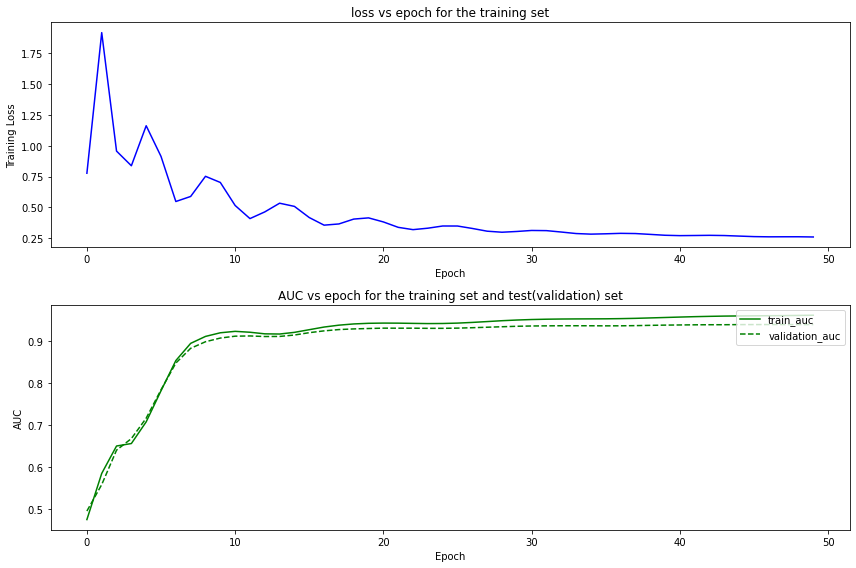

Train AUC: 0.961, Validation AUC: 0.939
Train Accuracy: 89.438 %
Validation Accuracy: 85.400 %


In [19]:
# plot the AUC and loss vs epoch for the training set and test set
# create figure for all the  plots
fig = plt.figure(figsize=(12, 8))

# create train loss plot and add lables and title
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(train_loss , color='blue')
ax1.set_ylabel('Training Loss')
ax1.set_xlabel("Epoch")
ax1.title.set_text('loss vs epoch for the training set')

# create AUC plot for train and test sets and add lables and title
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(train_auc, label='train_auc', color='green')
ax2.plot(test_auc, label='validation_auc', color='green', linestyle='--')
ax2.legend(loc=1)
ax2.set_ylabel('AUC')
ax2.set_xlabel("Epoch")
ax2.title.set_text('AUC vs epoch for the training set and test(validation) set')
# add spaces between the sub plots
plt.tight_layout()
plt.show()

# compute accurcay for ptinting
# apply the net with the test data
y_hat_test = net_34_lr(x_test_t)
# convert lables to 0 and 1
y_hat_test_class = np.where(y_hat_test.data.numpy() < 0.5, 0, 1)
# compute accuracy 
test_accuracy = np.sum(y_hat_test_class == y_test_t.data.numpy()) / len(y_hat_test_class)

# print measures
print('Train AUC: %.3f, Validation AUC: %.3f' % (train_auc[-1], test_auc[-1]))
print('Train Accuracy: %.3f %s' % (train_accuracy[-1] * 100, '%'))
print('Validation Accuracy: %.3f %s' % (test_accuracy * 100, '%'))

<b> explanation: </b><br>
As can be seen above, the training loss decreases as long as the number of Epochs increases. In addition, the AUC for the train data increases with the number of Epochs while the AUC of the validation data stops increasing from some point and therefore we chose 50 Epochs for the training stage. <br>
The test AUC and accuracy are similar for both torch and sklearn regressions. The train AUC and accuracy is a bit higher on the sklearn regression. We assume that this happened because we chose 100 Epochs for the tensor network in order to prevent overfitting. <br>
If we compare the net34 results to the net18, we got better results in the net34 on sklearn on all the metrics. On pytorch we got better results on all the metrics besides the validation AUC with net18 but the validation AUC is better with net34.

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [20]:
# merge the logistic regression (we did with pytorch) with the network
model_resnet_34.fc = net_34_lr

# Part 2- Fine-tuning

In the feature extraction experiment above you were training the classifier on the top of the pre-trained model. 
In this paert, you need to train (or "fine-tune") the original pre-trained Resnet18 model (or part of them) in an attempts to improve your results. You can determine the number of convolution layers you intend to re-train in order to avoid overfitting and hopefully achive better generalization. Note that the fine-tuning should only be attempted after you have trained the top-level classifier with a pre-trained model.

1. Plot Loss and Accuracy v.s Epoch for train and validation sets:

#### Define the model (use the merged feature extractor with the PyTorch logistic regression classifier)

In [24]:
# make a copy for the network we need
net_18_copy = copy.deepcopy(net_18_lr)
net_18_copy

Sequential(
  (0): Linear(in_features=512, out_features=1, bias=True)
  (1): Sigmoid()
)

In [25]:
# load resnet18 network
model_ft_resnet18 = models.resnet18(pretrained=True)
# merge the logistic regression (we did with pytorch) with the network
model_ft_resnet18.fc = net_18_copy

In [26]:
# for all the parameters define the gradients as not needing to be computed
for param in model_ft_resnet18.parameters():
    param.requires_grad = False

In [27]:
# unfreeze the weights o fthe 3 last layres and for them define the parameters's gradients as needing to be computed
for block in list(model_ft_resnet18.children())[-3:]:
    for name,param in block.named_parameters():
        param.requires_grad = True

In [28]:
# define DataLoader for each set (train/test)
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=1)

#### Training and validation:

In [29]:
# define the loss function (binary cross entropy for logistic), learning rate and the optimizer
criterion = nn.BCELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_ft_resnet18.parameters(), lr=learning_rate)

In [30]:
# the training function- get a model and dataloader and return the loss and accuracy for training
def fit(model, train_dataloader):
    # define that we are on train
    model.train()
    # initialize the loss and number of correct predicts for trainig
    train_total_loss = 0.0
    train_total_correct = 0
    # for each data in this loop
    for i, data in enumerate(train_dataloader):
        # divide the data to features and labels
        data, target = data[0], data[1]
        # resetting the gradinates
        optimizer.zero_grad()
        # get the output of the model with the data
        output = model(data)
        # compute the loss value with the predicted values of train with the true labels 
        loss = criterion(output, target.float().reshape(-1,1))
        # add the value to the total loss 
        train_total_loss += loss.item()
        # convert predictions to 0 or 1
        preds = np.where(output.detach().numpy() < 0.5, 0, 1)
        # sum the number of times that we correct and add this to the total times
        train_total_correct += (torch.tensor(preds) == target.reshape(-1,1)).sum().item()
        # apply the backward with the loss we got
        loss.backward()
        # apply step for the updates
        optimizer.step()
    # compute the avarage loss
    train_loss = train_total_loss/len(train_dataloader.dataset)
    # compute the avarage time we got correct predictions
    train_accuracy = 100. * train_total_correct/len(train_dataloader.dataset)
    # print the measures
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [31]:
# the validation function
def validate(model, test_dataloader):
    # define that we are on evaluate
    model.eval()
    # initialize the loss and number of correct predicts for validation
    validation_total_loss = 0.0
    validation_total_correct = 0
    # for each data in this loop
    for int, data in enumerate(test_dataloader):
        # divide the data to features and labels
        data, target = data[0], data[1]
        # get the output of the model with the data
        output = model(data)
        # compute the loss value with the predicted values of validation with the true labels 
        loss = criterion(output, target.float().reshape(-1,1))
        # add the value to the total loss 
        validation_total_loss += loss.item()
        # convert predictions to 0 or 1
        preds = np.where(output.detach().numpy() < 0.5, 0, 1)
        # sum the number of times that we correct and add this to the total times
        validation_total_correct += (torch.tensor(preds) == target.reshape(-1,1)).sum().item()
    # compute the avarage loss
    validation_loss = validation_total_loss/len(test_dataloader.dataset)
    # compute the avarage time we got correct predictions
    validation_accuracy = 100. * validation_total_correct/len(test_dataloader.dataset)
    # print the measures
    print(f'Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}')

    return validation_loss, validation_accuracy

In [32]:
# create lists for loss and accuracy that will save the parameters from the different iterations for the plots
train_loss = [] 
train_accuracy = []
validation_loss = []
validation_accuracy = []
# get the start time (when we start)
start = time.time()
# for each epoch
for epoch in range(15):
    # fit the model and get the loss and accuracy for the train in this epoch
    train_epoch_loss, train_epoch_accuracy = fit(model_ft_resnet18, train_loader)
    # validate the model and get the loss and accuracy for the validation in this epoch
    validation_epoch_loss, validation_epoch_accuracy = validate(model_ft_resnet18, test_loader)
    # apeend all the values to the correct list
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    validation_loss.append(validation_epoch_loss)
    validation_accuracy.append(validation_epoch_accuracy)
# get the end time (when we end)
end = time.time()
# print how much time it's take
print((end-start)/60, 'minutes')

Train Loss: 0.0176, Train Acc: 79.19
Validation Loss: 0.0155, Validation Acc: 84.00
Train Loss: 0.0026, Train Acc: 96.94
Validation Loss: 0.0161, Validation Acc: 84.40
Train Loss: 0.0009, Train Acc: 99.38
Validation Loss: 0.0172, Validation Acc: 84.20
Train Loss: 0.0003, Train Acc: 99.88
Validation Loss: 0.0180, Validation Acc: 84.00
Train Loss: 0.0003, Train Acc: 99.94
Validation Loss: 0.0189, Validation Acc: 85.20
Train Loss: 0.0002, Train Acc: 99.94
Validation Loss: 0.0204, Validation Acc: 84.80
Train Loss: 0.0001, Train Acc: 100.00
Validation Loss: 0.0207, Validation Acc: 84.00
Train Loss: 0.0001, Train Acc: 100.00
Validation Loss: 0.0205, Validation Acc: 85.00
Train Loss: 0.0002, Train Acc: 99.81
Validation Loss: 0.0214, Validation Acc: 84.20
Train Loss: 0.0001, Train Acc: 99.94
Validation Loss: 0.0227, Validation Acc: 84.20
Train Loss: 0.0001, Train Acc: 99.94
Validation Loss: 0.0228, Validation Acc: 84.20
Train Loss: 0.0001, Train Acc: 100.00
Validation Loss: 0.0224, Validation 

#### Visualizing the plots:

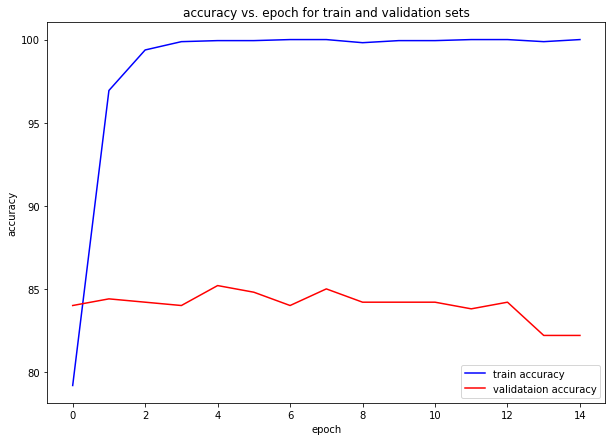

In [33]:
# create train and validation accuracy plots for each epoch and add lables and title
# create figure
plt.figure(figsize=(10, 7))
# plot
plt.plot(train_accuracy, color='blue', label='train accuracy')
plt.plot(validation_accuracy, color='red', label='validataion accuracy')
# add titles and labels
plt.title('accuracy vs. epoch for train and validation sets')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# add legend
plt.legend()
plt.show()

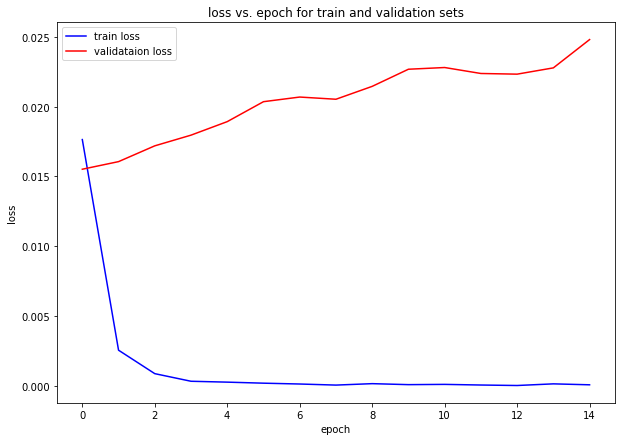

In [34]:
# create train and validation loss plots for each epoch and add lables and title
# create figure
plt.figure(figsize=(10, 7))
# plot
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(validation_loss, color='red', label='validataion loss')
# add titles and labels
plt.title('loss vs. epoch for train and validation sets')
plt.xlabel('epoch')
plt.ylabel('loss')
# add legend
plt.legend()
plt.show()

2. Compare your results between the two approaches. Is there any improvement? Explain your findings...


Fine-tuning results:
Train Acc: 100
Validation Acc: 82.2

Net18  Feature Extractor results: 
Train Accuracy: 90.750 %
Validation Accuracy: 84.800 %

We can see that on the fine tuning, there is a 17.8% difference between the train and validation accuracy. We can infer that there is an overfitting. 
In the fine tuning stage, we used the trained network from the Feature extractor stage and re-train the last 3 layers. 
As can be seen, the train accuracy increased to 100%. The validation accuracy descreased.
These facts indicate overfitting. 

Therefore, we would use the feature extractor stage and wouldn't continue to the fine-tuning stage.